In [21]:
# Imports

import os
from pathlib import Path
from dotenv import load_dotenv
import datetime
from datetime import date
import pandas as pd
import numpy as np
import time
import pytz
from datetime import timedelta
from sklearn.preprocessing import StandardScaler

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [22]:
# Download (if necessary) and Import Alpaca Trade API

#!pip install alpaca-trade-api
import alpaca_trade_api as tradeapi

#load_dotenv(abs_path)
load_dotenv()
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [23]:
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

# Illustration of the Data Generation Process

The data is generated in multiple steps, using a loop that pulls daily data (due to limitations of the Alpaca API and memory issues that are causedby pulling too much data at once). 

The process is illustrated below:

## 1) Creating the Ticker List

Each ticker list is generated on Quantopian using the 3 most liquid tickers from each of the 11 SPY sectors based on 100 day ADV on Dec 31st of each respetive year

and each ticker list should then be the basis for the names trades in the following year, so ticker_list_2016_Dec_31_corrected should be used to create the data for 2017

to prevent look ahead bias while staying with the most liquid names to prevent any problems with trading at such a high frequency

In [24]:
ticker_list = ['MSFT','TSLA','BRK.B','XOM','K']

## 2) Analyzing Price Behavior

### 2.1) Pulling Prices

In [25]:
def pullingPrices(start_date_str,numDays, ticker_list,timeframe='1Min', candle_part = 'close'):
    prices = pd.DataFrame()
    counter = 0
    for single_date in (datetime.datetime.strptime(start_date_str,"%Y-%m-%d") +datetime.timedelta(days=n) for n in range(numDays)):
        start =  pd.Timestamp(f'{single_date} 01:00:15-0400', tz='America/New_York').replace(hour=9, minute=30, second=15).astimezone('GMT').isoformat()[:-6]+'Z'
        end   =  pd.Timestamp(f'{single_date} 01:00:15-0400', tz='America/New_York').replace(hour=16, minute=0, second=15).astimezone('GMT').isoformat()[:-6]+'Z'
        df = api.get_barset(ticker_list, timeframe,limit=1000, start=start, end=end).df  

        bar_list= ['open','close','high', 'low', 'volume']
        # candle_part is the part of bar chart that we keep
        bar_list.remove(candle_part)
        df.drop(columns=bar_list, level=1, inplace=True)        
        df = df.droplevel(axis=1, level=1)
        #print(df.head)
        # We are using forward fill to fill data points that are missing with previous prices, since Alpaca reports minutes without any trades occuring as missing but technically the price is stil lthe same
        #df.ffill(inplace=True)    
        prices = pd.concat([prices,df],axis=0)
        counter = counter + 1
        if counter % 20 ==0:
            print(start)
    del df
    return prices

2015-01-20T14:30:15Z
2015-02-09T14:30:15Z
2015-03-01T14:30:15Z
2015-03-21T13:30:15Z
2015-04-10T13:30:15Z
2015-04-30T13:30:15Z
2015-05-20T13:30:15Z
2015-06-09T13:30:15Z
2015-06-29T13:30:15Z
2015-07-19T13:30:15Z
2015-08-08T13:30:15Z
2015-08-28T13:30:15Z
2015-09-17T13:30:15Z
2015-10-07T13:30:15Z
2015-10-27T13:30:15Z


sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/1D 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/1D 3 more time(s)...


2015-11-16T14:30:15Z


sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/1D 3 more time(s)...


2015-12-06T14:30:15Z


sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/1D 3 more time(s)...


<AxesSubplot:xlabel='time'>

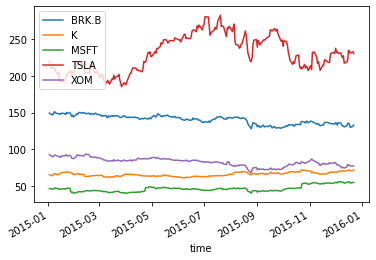

In [26]:
test = pullingPrices('2015-01-01',1,ticker_list, timeframe='1D')

In [27]:
test

,BRK.B,K,MSFT,TSLA,XOM
time,,,,,
2015-01-02 00:00:00-05:00,149.13,65.49,46.75,219.19,92.81
2015-01-05 00:00:00-05:00,147.07,64.27,46.33,210.01,90.34
2015-01-06 00:00:00-05:00,146.70,64.43,45.60,211.19,89.78
2015-01-07 00:00:00-05:00,148.81,66.00,46.23,210.81,90.72
2015-01-08 00:00:00-05:00,151.25,67.19,47.59,210.55,92.20
...,...,...,...,...,...
2015-12-16 00:00:00-05:00,135.88,71.97,56.12,234.51,79.13
2015-12-17 00:00:00-05:00,133.96,71.62,55.70,233.34,77.98
2015-12-18 00:00:00-05:00,129.87,70.78,54.18,230.56,77.30


In [94]:
start_date_str = '2008-01-02'
timeframe = "1D"
numDays = 50
ticker_list = ticker_list_2019_Dec_31_corrected # this should always be set to Dec 31st from the year prior to avoid lookahead bias
ticker_list = ticker_list_2015_Jan_01 
close_prices = pullingPrices(start_date_str,numDays, ticker_list,timeframe, candle_part = 'close')
close_prices.head()

2008-01-21T14:30:15Z
2008-02-10T14:30:15Z


,AABA,AAL,AAPL,ABBV,AEP,AGN,AIG,AMGN,AMT,AMZN,...,V,VER,VTR,VZ,WELL,WFC,WMT,X,XOM,ZG
2008-01-02 05:00:00+00:00,23.7300000000,NaN,27.8470000000,NaN,29.5800000000,63.3500000000,1126.8000000000,46.6000000000,41.2300000000,96.2100000000,...,NaN,NaN,44.4300000000,43.1900000000,45.1400000000,29.1000000000,46.9000000000,113.6000000000,93.5600000000,NaN
2008-01-03 05:00:00+00:00,23.8600000000,NaN,27.8360000000,NaN,29.6700000000,62.6300000000,1128.8000000000,39.1000000000,40.4200000000,95.1800000000,...,NaN,NaN,43.2200000000,43.4500000000,44.3100000000,28.5100000000,46.3900000000,112.0800000000,93.9100000000,NaN
2008-01-04 05:00:00+00:00,23.1500000000,NaN,25.7040000000,NaN,29.5700000000,62.1000000000,22122.0000000000,38.3400000000,39.3500000000,88.7400000000,...,NaN,NaN,41.2000000000,42.5400000000,43.0800000000,27.4800000000,45.6400000000,105.5400000000,92.0000000000,NaN
2008-01-07 05:00:00+00:00,23.1800000000,NaN,25.3690000000,NaN,30.4300000000,62.4600000000,22520.0000000000,45.3800000000,39.1300000000,88.8400000000,...,NaN,NaN,41.7600000000,43.3800000000,43.1500000000,27.7200000000,46.5800000000,100.9000000000,91.2400000000,NaN
2008-01-08 05:00:00+00:00,22.5499000000,NaN,24.4610000000,NaN,47.5300000000,64.1900000000,22209.8000000000,39.6500000000,37.9400000000,87.9200000000,...,NaN,NaN,41.1000000000,41.6100000000,42.2000000000,26.4300000000,45.9100000000,98.9500000000,89.9900000000,NaN


### 2.2) Computing Returns

In [101]:
def computingReturns(open_prices_df, close_prices_df, start_date_str, numDays,list_of_momentums,zScore=False): 
    total_returns = pd.DataFrame()
    open_prices_df.index = pd.to_datetime(open_prices_df.index,utc=True)
    close_prices_df.index = pd.to_datetime(close_prices_df.index,utc=True)    
    
    forecast=1
    addedLag=0 # if we use open prices as entry points, we need to shift by forecast +1, otherwise if we use close prices only this should be 0
    data =  open_prices_df.pct_change(forecast)      
    print(data.head())
    if zScore==True:        
        data = pd.DataFrame(StandardScaler().fit_transform(data))
        #or without look ahead bias
        #mean = data.rolling(window=3).apply(np.mean).shift(1)
        #std  = data.rolling(window=3).apply(np.std).shift(1)
        #data = (data - mean)/std
        data.index = open_prices_df.index
        data.columns = open_prices_df.columns
        print(data.head())
    data = data.shift(-(forecast+addedLag))
    data = pd.DataFrame(data.unstack())
    name = "F_"+str(forecast)+"_m_returns"
    data.rename(columns={0: name}, inplace = True)
    data.reset_index(inplace = True)
   
    for i in list_of_momentums:   
        feature = close_prices_df.pct_change(i)
        feature = pd.DataFrame(feature.unstack())
        name = str(i)+"_m_returns"
        feature.rename(columns={0: name}, inplace = True)
        feature.reset_index(inplace = True)

        data = pd.merge(data,feature,left_on=['level_0', 'level_1'],right_on=['level_0', 'level_1'], how='left', suffixes=('_original', 'right'))
   
    data.dropna(axis=0, how='any', inplace=True)
    # We stack all the individual days on top of each other at the endd
    
    total_returns = pd.concat([total_returns,data])

    #deleting the global prices dataframe here to conserve memory (you have to declare it first to be global before deleting it)
    try:
        global open_prices
        del open_prices
    except:
        pass
    try:   
        global close_prices
        #del close_prices
    except:
        pass
    return total_returns

### We can choose how many momentums and which ones we want to create

In [80]:
list_of_momentums = [1] # [1,2,3,4,5]
total_returns = computingReturns(close_prices, close_prices, start_date_str, numDays,list_of_momentums)

In [81]:
total_returns.tail()

,level_0,level_1,F_1_m_returns,1_m_returns
3326,XOM,2008-02-12 05:00:00+00:00,0.0124437070,0.0139389570
3327,XOM,2008-02-13 05:00:00+00:00,0.0002341098,0.0124437070
3328,XOM,2008-02-14 05:00:00+00:00,-0.0003510825,0.0002341098
3329,XOM,2008-02-15 05:00:00+00:00,0.0199016624,-0.0003510825
3330,XOM,2008-02-19 05:00:00+00:00,0.0121671258,0.0199016624


### We can verify that the returns are correctly computed below for the first row

level_0 	level_1 	F_1_m_returns 	1_m_returns
1 	AAPL 	2020-01-02 14:31:00+00:00 	0.00085 	-0.00081

To realize the F_1_m_returns in the first row, we need to buy:
    
    on the open at 2020-01-02 09:32:00-05:00 	295.78000 
                
and sell:
    
    on the open at 2020-01-02 09:33:00-05:00 	296.54000 	
    
diff = 295.78000  - 295.53000 
ret = diff/ 295.53000  = 0.00085
round(ret,5) 

The corresponding 1m return used to predict this one is:

From: 
    2020-01-02 09:30:00-05:00 295.74000
To:

    2020-01-02 09:31:00-05:00 	295.50000
    
diff =  295.50000 	 - 295.74000
ret = diff/    295.74000 =-0.00081
round(ret,5)

### 2.2) Converting Returns to Z-Scores

Below is an illustration of how z-scores are computed further below (notice that for each row the z-score using mean and std without that particular observation)

In [65]:
data = pd.DataFrame([1, 2, 5, 7, 9], columns=['A'])

data["mean"] = data["A"].rolling(window=3).apply(np.mean).shift(1)
data["std"] = data["A"].rolling(window=3).apply(np.std).shift(1)

data["COL_ZSCORE"] = (data["A"] - data["mean"])/data["std"]

print(data.head())

   A         mean          std   COL_ZSCORE
0  1          nan          nan          nan
1  2          nan          nan          nan
2  5          nan          nan          nan
3  7 2.6666666667 1.6996731712 2.5495097568
4  9 4.6666666667 2.0548046677 2.1088784747


In [66]:
diff = 7-2.6666666667

In [67]:
diff/1.6996731712

2.5495097567731735

In [72]:
from sklearn.preprocessing import StandardScaler
data["COL_ZSCORE2"] = StandardScaler().fit_transform(data[["A"]])

In [73]:
print(data.head())

   A         mean          std   COL_ZSCORE   COL_ZSCORE2
0  1          nan          nan          nan -1.2694908991
1  2          nan          nan          nan -0.9354143467
2  5          nan          nan          nan  0.0668153105
3  7 2.6666666667 1.6996731712 2.5495097568  0.7349684153
4  9 4.6666666667 2.0548046677 2.1088784747  1.4031215200


In [74]:
sum = 1+2+5+7+9

In [75]:
mu = np.mean([1,2,5,7,9])

In [76]:
std = np.std([1,2,5,7,9])

In [77]:
(1 - mu)/std

-1.269490899084016

In [86]:
total_returns.set_index(['level_0','level_1'], inplace=True)

In [102]:
total_returns_z = computingReturns(close_prices, close_prices, start_date_str, numDays,list_of_momentums,zScore=True)

                                   AABA  AAL          AAPL  ABBV  \
2008-01-02 05:00:00+00:00           nan  nan           nan   nan   
2008-01-03 05:00:00+00:00  0.0054782975  nan -0.0003950156   nan   
2008-01-04 05:00:00+00:00 -0.0297569153  nan -0.0765914643   nan   
2008-01-07 05:00:00+00:00  0.0012958963  nan -0.0130329910   nan   
2008-01-08 05:00:00+00:00 -0.0271829163  nan -0.0357917143   nan   

                                    AEP           AGN           AIG  \
2008-01-02 05:00:00+00:00           nan           nan           nan   
2008-01-03 05:00:00+00:00  0.0030425963 -0.0113654301  0.0017749379   
2008-01-04 05:00:00+00:00 -0.0033704078 -0.0084623982 18.5978029766   
2008-01-07 05:00:00+00:00  0.0290835306  0.0057971014  0.0179911400   
2008-01-08 05:00:00+00:00  0.5619454486  0.0276977265 -0.0137744227   

                                   AMGN           AMT          AMZN  ...   V  \
2008-01-02 05:00:00+00:00           nan           nan           nan  ... nan   
2008

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


In [103]:
total_returns_z.head()

,level_0,level_1,F_1_m_returns,1_m_returns
1,AABA,2008-01-03 05:00:00+00:00,-0.4348105999,0.0054782975
2,AABA,2008-01-04 05:00:00+00:00,-0.0869344853,-0.0297569153
3,AABA,2008-01-07 05:00:00+00:00,-0.4059747962,0.0012958963
4,AABA,2008-01-08 05:00:00+00:00,-0.1063703471,-0.0271829163
5,AABA,2008-01-09 05:00:00+00:00,0.6689216797,-0.0004390263


In [104]:
total_returns.head()

F_1_m_returns   1_m_returns  \
level_0 level_1                                                  
AABA    2008-01-03 05:00:00+00:00  -0.0297569153  0.0054782975   
        2008-01-04 05:00:00+00:00   0.0012958963 -0.0297569153   
        2008-01-07 05:00:00+00:00  -0.0271829163  0.0012958963   
        2008-01-08 05:00:00+00:00  -0.0004390263 -0.0271829163   
        2008-01-09 05:00:00+00:00   0.0687666371 -0.0004390263   

                                   F_1_m_returns_z  1_m_returns_z  
level_0 level_1                                                    
AABA    2008-01-03 05:00:00+00:00    -0.1001575002  -0.0667379651  
        2008-01-04 05:00:00+00:00    -0.0713232671  -0.0994523401  
        2008-01-07 05:00:00+00:00    -0.0977674014  -0.0706211442  
        2008-01-08 05:00:00+00:00    -0.0729342376  -0.0970624931  
        2008-01-09 05:00:00+00:00    -0.0086729960  -0.0722319450

## 3) Volume

### 3.1) Pulling Volume

In [80]:
def pullingVolume(start_date_str,numDays, ticker_list,timeframe='1Min'):
    total_volume = pd.DataFrame()        
    for single_date in (datetime.datetime.strptime(start_date_str,"%Y-%m-%d") +datetime.timedelta(days=n) for n in range(numDays)):
    
        start =  pd.Timestamp(f'{single_date} 01:00:00-0400', tz='America/New_York').replace(hour=9, minute=30).astimezone('GMT').isoformat()[:-6]+'Z'
        end   =  pd.Timestamp(f'{single_date} 01:00:00-0400', tz='America/New_York').replace(hour=16, minute=0).astimezone('GMT').isoformat()[:-6]+'Z'

        df = api.get_barset(
        ticker_list,
        timeframe,
        limit=1000,
        start=start,
        end=end,
        ).df

        df.drop(columns=['open', 'high', 'low', 'close'], level=1, inplace=True)
        df = df.droplevel(axis=1, level=1)
        #df.ffill(inplace=True)         
        #print(df.head())
        total_volume = pd.concat([total_volume,df],axis=0)            
    del df
    return total_volume

In [105]:
total_volume = pullingVolume(start_date_str,numDays, ticker_list, timeframe=timeframe)

In [107]:
total_volume.head()

,AABA,AAL,AAPL,ABBV,AEP,AGN,AIG,AMGN,AMT,AMZN,...,V,VER,VTR,VZ,WELL,WFC,WMT,X,XOM,ZG
2008-01-02 05:00:00+00:00,23946588,NaN,263616390,NaN,4091263,1695600,222916,7950945,2980650,13481385,...,NaN,NaN,1007215,8846023,541236,23219012,18534649,5306214,22055795,NaN
2008-01-03 05:00:00+00:00,19078062,NaN,204667791,NaN,2984765,1624762,506755,12358057,4389043,8638898,...,NaN,NaN,855353,7642749,849546,24869932,16871690,3003054,17952571,NaN
2008-01-04 05:00:00+00:00,19649845,NaN,352875628,NaN,5387252,1976972,33393,10079184,4596060,10015762,...,NaN,NaN,1758750,10157708,861900,49514094,19295369,3972888,22294711,NaN
2008-01-07 05:00:00+00:00,20509899,NaN,509363742,NaN,4693289,2082539,39719,8954480,3352500,9584246,...,NaN,NaN,1172112,12283755,763003,25076273,17999462,5540281,27132242,NaN
2008-01-08 05:00:00+00:00,21461501,NaN,371810332,NaN,4457312,2556985,43977,21203521,3086822,12053422,...,NaN,NaN,2087926,32519594,1144500,40424272,17766798,4055705,18820983,NaN


In [83]:
total_volume.tail()

,AABA,AAL,AAPL,ABBV,AEP,AGN,AIG,AMGN,AMT,AMZN,...,V,VER,VTR,VZ,WELL,WFC,WMT,X,XOM,ZG
2008-02-13 05:00:00+00:00,55474884,NaN,233272345,NaN,3068207,1260330,712641,8466336,2603351,10794259,...,NaN,NaN,875712,23046970,660100,30001160,15009245,4225493,19272484,NaN
2008-02-14 05:00:00+00:00,37002393,NaN,233830900,NaN,4370342,1822069,749288,7138320,2595381,7268147,...,NaN,NaN,705746,9802284,730712,24086891,17044105,4738772,19741801,NaN
2008-02-15 05:00:00+00:00,38324716,NaN,217981323,NaN,5325949,910904,51879,9045766,1817654,10860466,...,NaN,NaN,1104004,11421798,397200,25323285,24624271,3827625,21338234,NaN
2008-02-19 05:00:00+00:00,34814058,NaN,244735064,NaN,5184713,1271200,471647,7762467,3046170,6723315,...,NaN,NaN,1278621,33779770,474800,27818678,21311672,6298340,21373518,NaN
2008-02-20 05:00:00+00:00,28375288,NaN,236060960,NaN,4376611,2252411,469308,10252903,3130319,6230916,...,NaN,NaN,1000554,71683354,597191,28053011,21078880,5564902,23759510,NaN


In [144]:
total_volume['AABA']

2008-01-02 05:00:00+00:00     23946588
2008-01-03 05:00:00+00:00     19078062
2008-01-04 05:00:00+00:00     19649845
2008-01-07 05:00:00+00:00     20509899
2008-01-08 05:00:00+00:00     21461501
2008-01-09 05:00:00+00:00     45418561
2008-01-10 05:00:00+00:00     47146541
2008-01-11 05:00:00+00:00     25008824
2008-01-14 05:00:00+00:00     17780049
2008-01-15 05:00:00+00:00     30386666
2008-01-16 05:00:00+00:00     37004075
2008-01-17 05:00:00+00:00     27133469
2008-01-18 05:00:00+00:00     40195487
2008-01-22 05:00:00+00:00     35888806
2008-01-23 05:00:00+00:00     39405129
2008-01-24 05:00:00+00:00     39369585
2008-01-25 05:00:00+00:00     27134518
2008-01-28 05:00:00+00:00     29344885
2008-01-29 05:00:00+00:00     56426412
2008-01-30 05:00:00+00:00    105126974
2008-01-31 05:00:00+00:00     38752502
2008-02-01 05:00:00+00:00    357380019
2008-02-04 05:00:00+00:00    124412824
2008-02-05 05:00:00+00:00     66259120
2008-02-06 05:00:00+00:00     49763232
2008-02-07 05:00:00+00:00

### 3.2) Computing Volume Z-Score 

In [140]:
def computingZScore(total_volume_df, start_date_str, numDays, window=10):
    total_vol_z_score = pd.DataFrame()
    total_volume_df.drop(columns='SPY', inplace=True,errors='ignore') ## we are dropping SPY since we are only using it for the hedge
    
    def zscore_func(x):
        return (x[-1] - x[:-1].mean())/x[:-1].std(ddof=0)
    print('test1')
    df_temp = total_volume_df.rolling(window=window).apply(zscore_func)
    #df_temp.dropna(axis=1, how='any', inplace=True)
    total_vol_z_score = pd.concat([total_vol_z_score,df_temp])
    print('test2')
    print(total_vol_z_score.head())
    total_vol_z_score = pd.DataFrame(total_vol_z_score.unstack())
    print('test22')
    name = str(window)+"_m_vol_z_score"
    total_vol_z_score.rename(columns={0: name}, inplace = True)
    print('test23')
    total_vol_z_score.reset_index(inplace = True)
    print('test3')
    global total_volume
    #del total_volume
    return total_vol_z_score


In [141]:
total_vol_z_score = computingZScore(total_volume, start_date_str, numDays)
total_vol_z_score.head()

test1
test2
                           AABA  AAL  AAPL  ABBV  AEP  AGN  AIG  AMGN  AMT  \
2008-01-02 05:00:00+00:00   nan  nan   nan   nan  nan  nan  nan   nan  nan   
2008-01-03 05:00:00+00:00   nan  nan   nan   nan  nan  nan  nan   nan  nan   
2008-01-04 05:00:00+00:00   nan  nan   nan   nan  nan  nan  nan   nan  nan   
2008-01-07 05:00:00+00:00   nan  nan   nan   nan  nan  nan  nan   nan  nan   
2008-01-08 05:00:00+00:00   nan  nan   nan   nan  nan  nan  nan   nan  nan   

                           AMZN  ...   V  VER  VTR  VZ  WELL  WFC  WMT   X  \
2008-01-02 05:00:00+00:00   nan  ... nan  nan  nan nan   nan  nan  nan nan   
2008-01-03 05:00:00+00:00   nan  ... nan  nan  nan nan   nan  nan  nan nan   
2008-01-04 05:00:00+00:00   nan  ... nan  nan  nan nan   nan  nan  nan nan   
2008-01-07 05:00:00+00:00   nan  ... nan  nan  nan nan   nan  nan  nan nan   
2008-01-08 05:00:00+00:00   nan  ... nan  nan  nan nan   nan  nan  nan nan   

                           XOM  ZG  
2008-01-02 05

,level_0,level_1,10_m_vol_z_score
0,AABA,2008-01-02 05:00:00+00:00,nan
1,AABA,2008-01-03 05:00:00+00:00,nan
2,AABA,2008-01-04 05:00:00+00:00,nan
3,AABA,2008-01-07 05:00:00+00:00,nan
4,AABA,2008-01-08 05:00:00+00:00,nan


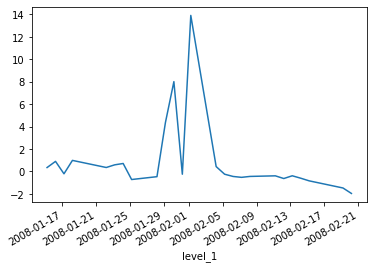

In [142]:
total_vol_z_score[total_vol_z_score['level_0']=='AABA'].dropna().set_index('level_1')['10_m_vol_z_score'].plot()

In [143]:
total_vol_z_score[total_vol_z_score['level_0']=='AABA'].dropna().set_index('level_1')['10_m_vol_z_score']

level_1
2008-01-15 05:00:00+00:00    0.3473968651
2008-01-16 05:00:00+00:00    0.8977497463
2008-01-17 05:00:00+00:00   -0.2102807015
2008-01-18 05:00:00+00:00    0.9848803369
2008-01-22 05:00:00+00:00    0.3518119237
2008-01-23 05:00:00+00:00    0.5892975313
2008-01-24 05:00:00+00:00    0.7092670348
2008-01-25 05:00:00+00:00   -0.7208206776
2008-01-28 05:00:00+00:00   -0.4671191941
2008-01-29 05:00:00+00:00    4.3637378393
2008-01-30 05:00:00+00:00    8.0100675795
2008-01-31 05:00:00+00:00   -0.2467020024
2008-02-01 05:00:00+00:00   13.9164909483
2008-02-04 05:00:00+00:00    0.4332972422
2008-02-05 05:00:00+00:00   -0.2463916705
2008-02-06 05:00:00+00:00   -0.4471671524
2008-02-07 05:00:00+00:00   -0.5264456491
2008-02-08 05:00:00+00:00   -0.4444179947
2008-02-11 05:00:00+00:00   -0.3916820159
2008-02-12 05:00:00+00:00   -0.6323848417
2008-02-13 05:00:00+00:00   -0.3869785613
2008-02-14 05:00:00+00:00   -0.6028474379
2008-02-15 05:00:00+00:00   -0.8388194975
2008-02-19 05:00:00+00:00 

### We set the tickers and the dates as index, all of the computations below assume that the dataframe is in this format so this is an important step

In [64]:
df = total_returns
del total_returns
df.set_index(['level_0','level_1'], inplace=True)

## As the final step we compute hedged returns

In [65]:
def computingHedgedReturns(row,df,name_of_returns):
    try:
        asset, date = row.name
        return df.loc[(asset, date), name_of_returns] - df.loc[('SPY',date), name_of_returns]
    except:
        print(asset)
        print(date)
        return np.nan

In [ ]:
tic = time.perf_counter()
df['excess_F_1_m_returns']  = df.apply(computingHedgedReturns, args=[df,'F_1_m_returns',], axis=1)
df['excess_1_m_returns']    = df.apply(computingHedgedReturns, args=[df,'1_m_returns',], axis=1)
toc = time.perf_counter()
print(f"Created the table in {(toc - tic)/60:0.2f} minutes")

In [13]:
df.head()


F_1_m_returns   1_m_returns  \
level_0 level_1                                                  
AAPL    2020-01-02 14:31:00+00:00   0.0008459378 -0.0008115236   
        2020-01-02 14:32:00+00:00   0.0025356684  0.0009475465   
        2020-01-02 14:33:00+00:00   0.0013489360  0.0025694773   
        2020-01-02 14:34:00+00:00   0.0011113731  0.0012140015   
        2020-01-02 14:35:00+00:00   0.0019847945  0.0016167060   

                                   excess_F_1_m_returns  excess_1_m_returns  
level_0 level_1                                                              
AAPL    2020-01-02 14:31:00+00:00          0.0007841121       -0.0001319660  
        2020-01-02 14:32:00+00:00          0.0016701619        0.0009475465  
        2020-01-02 14:33:00+00:00          0.0017195466        0.0017039976  
        2020-01-02 14:34:00+00:00          0.0003698771        0.0015846006  
        2020-01-02 14:35:00+00:00          0.0019539217        0.0008443382

In [14]:
df.tail()

F_1_m_returns   1_m_returns  \
level_0 level_1                                                  
XOM     2020-01-03 20:54:00+00:00   0.0002842524 -0.0001420858   
        2020-01-03 20:55:00+00:00   0.0000000000  0.0000710530   
        2020-01-03 20:56:00+00:00  -0.0004262575  0.0000710480   
        2020-01-03 20:57:00+00:00   0.0004264392 -0.0004262575   
        2020-01-03 20:58:00+00:00   0.0000000000  0.0005685856   

                                   excess_F_1_m_returns  excess_1_m_returns  
level_0 level_1                                                              
XOM     2020-01-03 20:54:00+00:00          0.0002222907        0.0004152587  
        2020-01-03 20:55:00+00:00         -0.0001239157        0.0000090913  
        2020-01-03 20:56:00+00:00          0.0002861697       -0.0000683572  
        2020-01-03 20:57:00+00:00          0.0002404562        0.0002706714  
        2020-01-03 20:58:00+00:00          0.0006508197        0.0003826083

## All of the the above is summarized in the function below

In [15]:
def createData(start_date_str,_ticker_list, timeframe, numDays,production=0,volumeOff=0):
    tic = time.perf_counter()
    list_of_momentums = [1] # [1,2,3,4,5,10,15,30,60]: 
    forecast = 1
    lag = 0
    if production==0: print("Pulling Prices")
    global open_prices
    global close_prices
    open_prices  = pullingPrices(start_date_str,numDays, ticker_list, candle_part = 'open')
    close_prices = pullingPrices(start_date_str,numDays, ticker_list, candle_part = 'close')

    if production==0: print("Creating Returns now")    
    total_returns = computingReturns(open_prices, close_prices, start_date_str, numDays,list_of_momentums)     
        
    df = total_returns
    
    print(df.head())
    df.set_index(['level_0','level_1'], inplace=True)    

    if production==0: print(f"Computing Hedged {forecast}m Forward Returns")
    df['excess_F_1_m_returns']  = df.apply(computingHedgedReturns, args=[df,'F_1_m_returns',], axis=1)
    for i in list_of_momentums: 
        if production==0: print(f"Computing Hedged {i}m Returns")
        df[f'excess_{i}_m_returns']    = df.apply(computingHedgedReturns, args=[df,f'{i}_m_returns',], axis=1)

    toc = time.perf_counter()
    print(f"Created the table in {(toc - tic)/60:0.2f} minutes")
    return df

In [16]:
start_date_str = '2019-01-01'
timeframe = '1Min'
numDays = 365
ticker_list = ticker_list_2014_Dec_31_corrected # this should always be set to Dec 31st from the year prior to avoid lookahead bias
df = createData(start_date_str, ticker_list,  timeframe, numDays,production=0, volumeOff=1)
df.to_csv('../data/no_lag_using_open_tickers_2014/df_2019_1m_no_lag_using_open.csv')

Pulling Prices
Creating Returns now
  level_0                   level_1  F_1_m_returns   1_m_returns
1     AAL 2019-01-02 14:31:00+00:00  -0.0006365372 -0.0014319809
2     AAL 2019-01-02 14:32:00+00:00   0.0003184713  0.0012746973
3     AAL 2019-01-02 14:33:00+00:00  -0.0060490290  0.0003182686
4     AAL 2019-01-02 14:34:00+00:00   0.0025624600 -0.0044543430
5     AAL 2019-01-02 14:35:00+00:00   0.0025559105  0.0009587728
Computing Hedged 1m Forward Returns
Computing Hedged 1m Returns
Created the table in 151.89 minutes


In [ ]:
start_date_str = '2020-01-01'
timeframe = '1Min'
numDays = 365
ticker_list = ticker_list_2019_Dec_31_corrected # this should always be set to Dec 31st from the year prior to avoid lookahead bias
df = createData(start_date_str, ticker_list,  timeframe, numDays,production=0, volumeOff=1)
df.to_csv('../data/no_lag_using_open/df_2020_1m_no_lag_using_open.csv')

### df.info()

In [10]:
df = df0
df.dropna(axis=0, inplace=True)
df.isna().mean()

F_1_m_returns          0.0000000000
1_m_returns            0.0000000000
excess_F_1_m_returns   0.0000000000
excess_1_m_returns     0.0000000000
dtype: float64

In [11]:
df['Dummy'] =np.where(df['excess_1_m_returns']>0,1,0)
df.reset_index(inplace=True)
df.level_1  = pd.to_datetime(df.level_1)
df.set_index(['level_0','level_1'], inplace=True)
df.head()

F_1_m_returns   1_m_returns  \
level_0 level_1                                                  
AAL     2015-01-02 14:31:00+00:00   0.0027731559 -0.0089842318   
        2015-01-02 14:32:00+00:00  -0.0023967552  0.0051803885   
        2015-01-02 14:33:00+00:00   0.0044354094 -0.0031290263   
        2015-01-02 14:34:00+00:00   0.0000000000 -0.0011078287   
        2015-01-02 14:35:00+00:00  -0.0014719411  0.0044362292   

                                   excess_F_1_m_returns  excess_1_m_returns  \
level_0 level_1                                                               
AAL     2015-01-02 14:31:00+00:00          0.0018527916       -0.0091780490   
        2015-01-02 14:32:00+00:00         -0.0029291077        0.0040177105   
        2015-01-02 14:33:00+00:00          0.0050158486       -0.0036129129   
        2015-01-02 14:34:00+00:00         -0.0006291743       -0.0003823498   
        2015-01-02 14:35:00+00:00         -0.0014719411        0.0038070244   

                                   Dummy  
level_0 level_1                           
AAL     2015-01-02 14:31:00+00:00      0  
        2015-01-02 14:32:00+00:00      1  
        2015-01-02 14:33:00+00:00      0  
        2015-01-02 14:34:00+00:00      0  
        2015-01-02 14:35:00+00:00      1

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 12504214 entries, ('AAL', Timestamp('2015-01-02 14:31:00+0000', tz='UTC')) to ('XOM', Timestamp('2018-12-31 20:58:00+0000', tz='UTC'))
Data columns (total 5 columns):
 #   Column                Dtype  
---  ------                -----  
 0   F_1_m_returns         float64
 1   1_m_returns           float64
 2   excess_F_1_m_returns  float64
 3   excess_1_m_returns    float64
 4   Dummy                 int64  
dtypes: float64(4), int64(1)
memory usage: 539.6+ MB


In [13]:
m = df.Dummy.diff().ne(0).cumsum()
counters = df.groupby([df.index.get_level_values(0), df.index.get_level_values(1).date, m]).cumcount()+1
df['Counter'] = np.where(df['Dummy']==0, -1, 1) * counters
df['Counter'] = df['Counter'].shift(1)
df[df['Counter'] ==-388]

F_1_m_returns   1_m_returns  \
level_0 level_1                                                  
T       2015-01-02 14:31:00+00:00   0.0005931198 -0.0011848341   
        2015-01-05 14:31:00+00:00   0.0014797277  0.0008883625   
        2015-01-06 14:31:00+00:00  -0.0008902077  0.0014850015   
        2015-01-07 14:31:00+00:00  -0.0014943216 -0.0011922504   
        2015-01-08 14:31:00+00:00   0.0021097046 -0.0003009329   
...                                          ...           ...   
        2018-12-21 14:31:00+00:00  -0.0013927577  0.0015704066   
        2018-12-26 14:32:00+00:00   0.0047307132 -0.0021786492   
        2018-12-27 14:31:00+00:00  -0.0028828829  0.0000000000   
        2018-12-28 14:31:00+00:00   0.0005289140  0.0007047216   
        2018-12-31 14:31:00+00:00   0.0001758396 -0.0028410087   

                                   excess_F_1_m_returns  excess_1_m_returns  \
level_0 level_1                                                               
T       2015-01-02 14:31:00+00:00         -0.0003272445       -0.0013786514   
        2015-01-05 14:31:00+00:00          0.0011367922        0.0016226847   
        2015-01-06 14:31:00+00:00         -0.0009892667        0.0022274287   
        2015-01-07 14:31:00+00:00         -0.0013701412       -0.0002989945   
        2015-01-08 14:31:00+00:00          0.0025505570       -0.0008890817   
...                                                 ...                 ...   
        2018-12-21 14:31:00+00:00         -0.0020425830        0.0018546474   
        2018-12-26 14:32:00+00:00          0.0034220337       -0.0027277981   
        2018-12-27 14:31:00+00:00         -0.0006614834       -0.0019784024   
        2018-12-28 14:31:00+00:00          0.0021916408        0.0009850693   
        2018-12-31 14:31:00+00:00         -0.0001047215       -0.0028009318   

                                   Dummy         Counter  
level_0 level_1                                           
T       2015-01-02 14:31:00+00:00      0 -388.0000000000  
        2015-01-05 14:31:00+00:00      1 -388.0000000000  
        2015-01-06 14:31:00+00:00      1 -388.0000000000  
        2015-01-07 14:31:00+00:00      0 -388.0000000000  
        2015-01-08 14:31:00+00:00      0 -388.0000000000  
...                                  ...             ...  
        2018-12-21 14:31:00+00:00      1 -388.0000000000  
        2018-12-26 14:32:00+00:00      0 -388.0000000000  
        2018-12-27 14:31:00+00:00      0 -388.0000000000  
        2018-12-28 14:31:00+00:00      1 -388.0000000000  
        2018-12-31 14:31:00+00:00      0 -388.0000000000  

[996 rows x 6 columns]

In [14]:
df=df[df.index.get_level_values(0)!='SPY']
df=df[df.index.get_level_values(0)!='T']
#df=df[df.index.get_level_values(0)!='TGT']

In [15]:
df.describe()

,F_1_m_returns,1_m_returns,excess_F_1_m_returns,excess_1_m_returns,Dummy,Counter
count,11726265.0000000000,11726265.0000000000,11726265.0000000000,11726265.0000000000,11726265.0000000000,11726264.0000000000
mean,-0.0000000697,-0.0000000116,0.0000000215,-0.0000000479,0.4855653527,-0.1046859426
std,0.0007288991,0.0007585879,0.0006888693,0.0007124571,0.4997916188,2.2555207757
min,-0.0829579167,-0.1237974684,-0.0772822410,-0.1176707419,0.0000000000,-23.0000000000
25%,-0.0002286585,-0.0002327566,-0.0002504474,-0.0002507258,0.0000000000,-1.0000000000
50%,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,-1.0000000000
75%,0.0002283031,0.0002325852,0.0002504094,0.0002504581,1.0000000000,1.0000000000
max,0.1149624495,0.1125000000,0.1086288815,0.1173413125,1.0000000000,23.0000000000


In [16]:
df[df.loc[:,'Counter'] ==-139].loc[:,'Counter']

Series([], Name: Counter, dtype: float64)

In [17]:
df[df['Counter']<-30].head()

,,F_1_m_returns,1_m_returns,excess_F_1_m_returns,excess_1_m_returns,Dummy,Counter
level_0,level_1,,,,,,


In [18]:
df[df.index.get_level_values(0)=='T'].head()

,,F_1_m_returns,1_m_returns,excess_F_1_m_returns,excess_1_m_returns,Dummy,Counter
level_0,level_1,,,,,,


In [19]:
df['abs_Counter'] = np.where(df['Counter']<0, df['Counter']*(-1),  df['Counter']) 

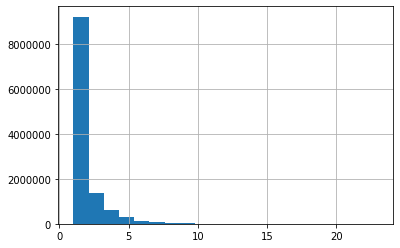

In [20]:
df.abs_Counter.hist(bins=20)

# Machine Learning

In [21]:
df.replace([np.inf, -np.inf], np.nan,inplace=True)

In [22]:
df.replace([np.inf, -np.inf], np.nan,inplace=True)
df.dropna(inplace=True,axis=0)
X = df.drop(columns=['F_1_m_returns','excess_F_1_m_returns'])
# we can drop various columns depending on what we want to use for prediction
#X.drop(columns=['60_m_vol_z_score'], inplace=True)
X.drop(columns=['1_m_returns', 'Dummy', 'abs_Counter'], inplace=True)
#X.drop(columns=['1_m_returns','2_m_returns','3_m_returns','4_m_returns','5_m_returns','10_m_returns','15_m_returns','30_m_returns','60_m_returns','60_m_vol_z_score'], inplace=True)
#X.drop(columns=['excess_2_m_returns','excess_3_m_returns','excess_4_m_returns','excess_5_m_returns','excess_10_m_returns','excess_15_m_returns','excess_30_m_returns','excess_60_m_returns'], inplace=True)
# creating the target variable
y = np.where(df['excess_F_1_m_returns']>-0.0000000000000,1,0)

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [24]:
X.describe()

,excess_1_m_returns,Counter
count,11726264.0000000000,11726264.0000000000
mean,-0.0000000471,-0.1046859426
std,0.0007124521,2.2555207757
min,-0.1176707419,-23.0000000000
25%,-0.0002507258,-1.0000000000
50%,0.0000000000,-1.0000000000
75%,0.0002504581,1.0000000000
max,0.1173413125,23.0000000000


In [ ]:
df['quantiles']= df.groupby(df.index.get_level_values(1))['excess_1_m_returns'].apply(lambda x: pd.qcut(x, q=5, labels=False, precision=0, duplicates='drop'))
df.groupby('quantiles')[['excess_F_1_m_returns']].mean().plot(kind='bar', legend=True)
df.groupby('quantiles')[['excess_F_1_m_returns']].mean()

In [ ]:
df['quantiles']= df.groupby(df.index.get_level_values(1))['Counter'].apply(lambda x: pd.qcut(x, q=5, labels=False, precision=0, duplicates='drop'))

In [ ]:
df['excess_F_1_m_returns*100,000']= df['excess_F_1_m_returns']*100000
df.groupby('quantiles')[['excess_F_1_m_returns*100,000','Counter']].mean().plot(kind='bar', legend=True)


In [ ]:
df.groupby('quantiles')[['excess_F_1_m_returns','Counter']].mean()

In [ ]:
import seaborn as sns
sns.jointplot(x=df["excess_F_1_m_returns"], y=df["excess_1_m_returns"], kind='scatter')

In [ ]:
X.head()

In [31]:
from sklearn.linear_model import LogisticRegression
steps = [('scaler', StandardScaler()),
         ('model',LogisticRegression())]         
pipeline = Pipeline(steps)        
cv=pipeline
cv.fit(X,y)    
y_pred = cross_val_predict(cv, X, y)        
print(confusion_matrix(y, y_pred))        
print(classification_report(y, y_pred, digits=4))

[[6029742    5012]
 [5685798    5712]]
              precision    recall  f1-score   support

           0     0.5147    0.9992    0.6794   6034754
           1     0.5326    0.0010    0.0020   5691510

    accuracy                         0.5147  11726264
   macro avg     0.5237    0.5001    0.3407  11726264
weighted avg     0.5234    0.5147    0.3506  11726264



In [25]:
import statsmodels.api as sm 
import pandas as pd
log_reg = sm.Logit(y, X).fit() 
print(log_reg.summary()) 

Optimization terminated successfully.
         Current function value: 0.693137
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:             11726264
Model:                          Logit   Df Residuals:                 11726262
Method:                           MLE   Df Model:                            1
Date:                Tue, 06 Oct 2020   Pseudo R-squ.:              -0.0006036
Time:                        03:31:34   Log-Likelihood:            -8.1279e+06
converged:                       True   LL-Null:                   -8.1230e+06
Covariance Type:            nonrobust   LLR p-value:                     1.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
excess_1_m_returns   -11.9804      0.823    -14.559      0.000     -13.593     -10.368
Count

In [ ]:
from sklearn.tree import DecisionTreeClassifier
steps = [('scaler', StandardScaler()),
         ('model',DecisionTreeClassifier(random_state=0))]         
pipeline = Pipeline(steps)        
y_pred = cross_val_predict(pipeline, X, y)        
print(confusion_matrix(y, y_pred))        
print(classification_report(y, y_pred, digits=4))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
steps = [('scaler', StandardScaler()),
         ('model',RandomForestClassifier(random_state=0))]         
pipeline = Pipeline(steps)        
y_pred = cross_val_predict(pipeline, X, y)   
print(confusion_matrix(y, y_pred))        
print(classification_report(y, y_pred, digits=4))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
steps = [('scaler', StandardScaler()),
         ('model',GradientBoostingClassifier(random_state=0))]         
pipeline = Pipeline(steps)        
y_pred = cross_val_predict(pipeline, X, y)       
print(confusion_matrix(y, y_pred))        
print(classification_report(y, y_pred, digits=4))  

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
steps = [('scaler', StandardScaler()),
         ('model',AdaBoostClassifier(random_state=2108))]         
pipeline = Pipeline(steps)        
y_pred = cross_val_predict(pipeline, X, y)        
print(confusion_matrix(y, y_pred))        
print(classification_report(y, y_pred, digits=4))

In [ ]:
!pip install xgboost
from xgboost import XGBClassifier
steps = [('scaler', StandardScaler()),
         ('model',XGBClassifier())]         
pipeline = Pipeline(steps)        
y_pred = cross_val_predict(pipeline, X, y)          
print(confusion_matrix(y, y_pred))        
print(classification_report(y, y_pred, digits=4))

# Return Analysis

In [26]:
#!pip install hvplot
#import hvplot.pandas  # noqa
numPositions =30
invested_fraction = 1/30
def returnAnalysis(df,y_pred,returns='F_1_m_returns',invested_fraction = invested_fraction):
    import gc
    gc.collect()
    nameOfModel = 'XGBClassifier'
    y_pred2  = pd.DataFrame(y_pred, index=df.index)
    y_pred2  = y_pred2.rename(columns={y_pred2.columns[0]: nameOfModel})
    y_pred2  = y_pred2.reset_index()
    y_pred2  = y_pred2.drop_duplicates()
    data2 = pd.merge(df,y_pred2, how='left', left_on=['level_0', 'level_1'],right_on=['level_0', 'level_1'])
    y_temp= data2[(data2[nameOfModel]==1)]
    print(y_temp[returns].describe())
    # We are computing the mean return per minute
    df_returns=pd.DataFrame(y_temp.groupby('level_1')[returns].apply(lambda x: x.mean()))
    print(df_returns.head())
    print(df_returns.describe())
    #df_returns_sp500=pd.DataFrame(df[df.index.get_level_values(0)=='SPY'].reset_index().groupby('level_1')['F_1_m_returns'].mean())
    # We are counting the number of trades per minute
    df_count=pd.DataFrame(y_temp.groupby('level_1')[returns].apply(lambda x: x.count()))
    print(df_count.head())
    print(df_count.describe())
    # For every minute we equally weight each position by dividing the mean return per minute by the number of po
    invested_fraction = 1/df_count
    # when invested fraction is set to 1/df_count, they both cancel out below (but we keep the computation below as for cases where invested fraction is a constant)
    df_tot_returns=pd.DataFrame(df_returns*df_count*invested_fraction)
    #df_tot_returns_sp500 =pd.DataFrame(df_returns_sp500*df_count*invested_fraction)
    df_cum_returns=pd.DataFrame(((df_tot_returns/100)+1).cumprod())
    #df_cum_returns_sp500=pd.DataFrame(((df_tot_returns_sp500/100)+1).cumprod())
    df_cum_returns.plot()
    df_returns.plot()
    df_count.plot()    
    sharpe_ratio = df_returns.mean() * 390 * 252 / (df_returns.std() * np.sqrt(390*250))
    print(f"Sharpe Ratio: {sharpe_ratio}")

In [37]:
import gc
gc.collect()

65

In [ ]:
df.drop(columns=['F_1_m_returns','1_m_returns','excess_1_m_returns','Dummy','Counter','abs_Counter'],inplace=True)

In [39]:
returnAnalysis(df,y_pred,returns='excess_F_1_m_returns',invested_fraction = invested_fraction)

MemoryError: cannot allocate memory for array

# Saving the model for Production

In [ ]:
!pip install joblib
#from sklearn.externals import joblib 
import joblib
joblib.dump(cv, '../models/log_reg_9_18_2020_trained_on_2015_1m_hedged_with_30_tickers.pkl')

# Out of Sample Tests

## Loading previously saved data

In [4]:
import time
tic = time.perf_counter()
df_2015 = pd.read_csv('../data/no_lag_using_open/df_2015_1m_no_lag_using_open.csv')
toc = time.perf_counter()
df_2015.set_index(['level_0', 'level_1'], inplace=True)
print(f"loaded the table in {(toc - tic)/60:0.2f} minutes")

loaded the table in 0.08 minutes


In [5]:
import time
tic = time.perf_counter()
df_2016 = pd.read_csv('../data/no_lag_using_open/df_2016_1m_no_lag_using_open.csv')
toc = time.perf_counter()
df_2016.set_index(['level_0', 'level_1'], inplace=True)
print(f"loaded the table in {(toc - tic)/60:0.2f} minutes")

loaded the table in 0.08 minutes


In [6]:
import time
tic = time.perf_counter()
df_2017 = pd.read_csv('../data/no_lag_using_open/df_2017_1m_no_lag_using_open.csv')
toc = time.perf_counter()
df_2017.set_index(['level_0', 'level_1'], inplace=True)
print(f"loaded the table in {(toc - tic)/60:0.2f} minutes")

loaded the table in 0.09 minutes


In [7]:
import time
tic = time.perf_counter()
df_2018 = pd.read_csv('../data/no_lag_using_open/df_2018_1m_no_lag_using_open.csv')
toc = time.perf_counter()
df_2018.set_index(['level_0', 'level_1'], inplace=True)
print(f"loaded the table in {(toc - tic)/60:0.2f} minutes")

loaded the table in 0.09 minutes


In [8]:
import time
tic = time.perf_counter()
df_2019 = pd.read_csv('../data/no_lag_using_open/df_2019_1m_no_lag_using_open.csv')
toc = time.perf_counter()
df_2019.set_index(['level_0', 'level_1'], inplace=True)
print(f"loaded the table in {(toc - tic)/60:0.2f} minutes")

loaded the table in 0.09 minutes


In [13]:
import time
tic = time.perf_counter()
df_2020 = pd.read_csv('../data/no_lag_using_open/df_2020_1m_no_lag_using_open.csv')
toc = time.perf_counter()
df_2020.set_index(['level_0', 'level_1'], inplace=True)
print(f"loaded the table in {(toc - tic)/60:0.2f} minutes")

loaded the table in 0.07 minutes


In [8]:
df0 = pd.concat([df_2015,df_2016,df_2017,df_2018])

In [23]:
df1 = pd.concat([df_2017,df_2018,df_2019])

In [12]:
df2 = pd.concat([df_2019,df_2020])

In [9]:
del df_2015
del df_2016
del df_2017
del df_2018
#del df_2019
#del df_2020
import gc
gc.collect()

0

In [57]:
df.to_csv('../data/no_lag_using_open/df_2015_to_2020_1m_no_lag_using_open.csv')

In [ ]:
!pip install joblib
#from sklearn.externals import joblib 
import joblib
# Load the model from the file 
model = joblib.load('../models/log_reg_9_18_2020_trained_on_2015_1m_hedged_with_30_tickers.pkl')

In [ ]:
y_pred= model.predict(X)

In [ ]:
returnAnalysis(df,y_pred,returns='F_1_m_returns',invested_fraction = 0.1)

In [88]:
df

F_1_m_returns   1_m_returns  \
level_0 level_1                                                  
AAL     2015-01-02 14:32:00+00:00  -0.0023967552  0.0051803885   
        2015-01-02 14:33:00+00:00   0.0044354094 -0.0031290263   
        2015-01-02 14:34:00+00:00   0.0000000000 -0.0011078287   
        2015-01-02 14:35:00+00:00  -0.0014719411  0.0044362292   
        2015-01-02 14:36:00+00:00  -0.0016583748 -0.0001840265   
...                                          ...           ...   
XOM     2016-12-30 20:54:00+00:00   0.0004438034  0.0001664170   
        2016-12-30 20:55:00+00:00   0.0005545082  0.0003327787   
        2016-12-30 20:56:00+00:00   0.0006650410  0.0004435573   
        2016-12-30 20:57:00+00:00   0.0005538325  0.0008867213   
        2016-12-30 20:58:00+00:00   0.0000000000  0.0003322259   

                                   excess_F_1_m_returns  excess_1_m_returns  \
level_0 level_1                                                               
AAL     2015-01-02 14:32:00+00:00         -0.0029291077        0.0040177105   
        2015-01-02 14:33:00+00:00          0.0050158486       -0.0036129129   
        2015-01-02 14:34:00+00:00         -0.0006291743       -0.0003823498   
        2015-01-02 14:35:00+00:00         -0.0014719411        0.0038070244   
        2015-01-02 14:36:00+00:00         -0.0018518452       -0.0001840265   
...                                                 ...                 ...   
XOM     2016-12-30 20:54:00+00:00         -0.0003187678       -0.0000130397   
        2016-12-30 20:55:00+00:00          0.0005993311       -0.0003624912   
        2016-12-30 20:56:00+00:00         -0.0002762831        0.0004435573   
        2016-12-30 20:57:00+00:00          0.0001955701       -0.0001442527   
        2016-12-30 20:58:00+00:00         -0.0007162682        0.0000411638   

                                   Dummy       Counter  abs_Counter  
level_0 level_1                                                      
AAL     2015-01-02 14:32:00+00:00      1 -1.0000000000 1.0000000000  
        2015-01-02 14:33:00+00:00      0  1.0000000000 1.0000000000  
        2015-01-02 14:34:00+00:00      0 -1.0000000000 1.0000000000  
        2015-01-02 14:35:00+00:00      1 -2.0000000000 2.0000000000  
        2015-01-02 14:36:00+00:00      0  1.0000000000 1.0000000000  
...                                  ...           ...          ...  
XOM     2016-12-30 20:54:00+00:00      0 -1.0000000000 1.0000000000  
        2016-12-30 20:55:00+00:00      0 -2.0000000000 2.0000000000  
        2016-12-30 20:56:00+00:00      1 -3.0000000000 3.0000000000  
        2016-12-30 20:57:00+00:00      0  1.0000000000 1.0000000000  
        2016-12-30 20:58:00+00:00      1 -1.0000000000 1.0000000000  

[5745883 rows x 7 columns]

# Model Directory

model_v1: trained on 10-5-2020 using data from 2015 to 2020, using the respective tickers for each year and using 1 m mom, and counter, and predicint open to open